In [1]:
!unzip Images.zip

unzip:  cannot find or open Images.zip, Images.zip.zip or Images.zip.ZIP.


In [2]:
!unzip Airplanes_Annotations.zip

unzip:  cannot find or open Airplanes_Annotations.zip, Airplanes_Annotations.zip.zip or Airplanes_Annotations.zip.ZIP.


In [3]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [4]:
path = "Images"
annot = "Airplanes_Annotations"

airplane_470.jpg
img filename Images/airplane_470.jpg
df filename Airplanes_Annotations/airplane_470.csv


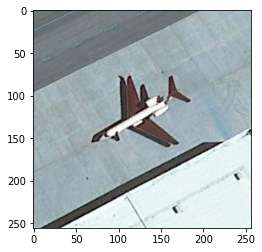

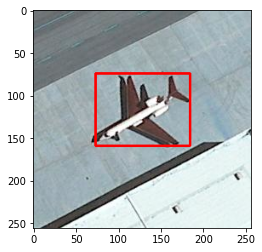

In [5]:
# 견본 이미지와 CSV로 어떤 정보가 있는지 확인
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        
        print("img filename", os.path.join(path,filename))
        print("df filename", os.path.join(annot,i))
        
        # show original image
        plt.imshow(img)

        # data frame 에서 네모 좌표값을 획득하여, 이미지 위에 그려준다
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)

        plt.figure()
        plt.imshow(img)
        break

In [6]:
# selective search 테스트
# selective search 오브젝트 생성
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

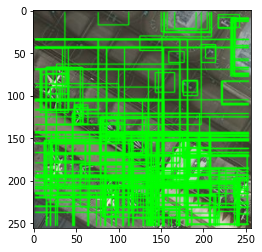

In [7]:
# selective search 사용법 확인
im = cv2.imread(os.path.join(path,"42845.jpg"))

ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
# 오브젝트 찾기 작업
rects = ss.process()
imOut = im.copy()

for i, rect in (enumerate(rects)):
    # 찾은 오브젝트들 반복하면서 네모를 그려준다
    x, y, w, h = rect
    #print(x,y,w,h)
    #imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()

plt.imshow(imOut)

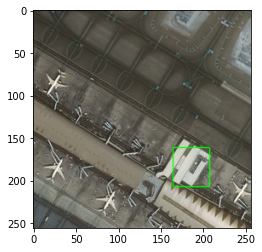

In [8]:
# test code
# selective search로 찾아낸 네모중에 1개를 그려본다.

imOut1 = im.copy()

rrr = rects[14]
x1, y1, w1, h1 = rrr
cv2.rectangle(imOut1, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut1)

In [9]:
train_images=[]
train_labels=[]

In [10]:
# iou 중첩도 계산 (데이터 셋과 비교하여, 비행기 인지 찾기)
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # get Minimum size box
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [12]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            # load dataset
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]

            # get airplain location
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

            #print(gtvalues) # airplain location value
                
            # selective search process
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()

            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0

            for e,result in enumerate(ssresults):
                # selective search는 2000개 정도의 ragion을 생성함다 (네모)
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        #print(x,y,w,h)
                        
                        # gtvalues : any one in csv data
                        # x, w, y, h : any one in selective search data
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})

                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter < 30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)

        continue

0 airplane_470.jpg
1 airplane_030.jpg
2 airplane_174.jpg
3 airplane_072.jpg
4 airplane_647.jpg
5 airplane_479.jpg
7 airplane_292.jpg
8 airplane_318.jpg
9 airplane_099.jpg
10 airplane_074.jpg
11 airplane_240.jpg
12 airplane_272.jpg
13 airplane_651.jpg
14 airplane_492.jpg
15 airplane_252.jpg
16 airplane_457.jpg
17 airplane_236.jpg
18 airplane_510.jpg
20 airplane_245.jpg
21 airplane_600.jpg
22 airplane_566.jpg
23 airplane_273.jpg
24 airplane_426.jpg
25 airplane_698.jpg
26 airplane_507.jpg
27 airplane_175.jpg
28 airplane_146.jpg
29 airplane_281.jpg
30 airplane_333.jpg
31 airplane_541.jpg
32 airplane_621.jpg
inside
33 airplane_168.jpg
34 airplane_620.jpg
35 airplane_652.jpg
36 airplane_467.jpg
37 airplane_636.jpg
38 airplane_138.jpg
39 airplane_591.jpg
40 airplane_555.jpg
inside
41 airplane_121.jpg
inside
42 airplane_037.jpg
43 airplane_119.jpg
inside
44 airplane_328.jpg
inside
45 airplane_380.jpg
46 airplane_665.jpg
47 airplane_542.jpg
48 airplane_458.jpg
49 airplane_066.jpg
50 airplane_56

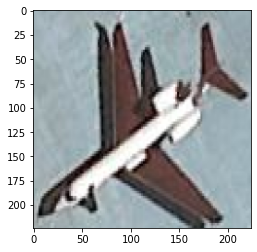

In [13]:
# 구분해낸 데이터에서 labels갑과 image가 일치하는지 확인
# labels 값이 1이면 이미지가 비행기이다!

X_new = np.array(train_images)
y_new = np.array(train_labels)

for i,iter in enumerate(train_images):
    if train_labels[i] == 1:    # 라벨값이 참이면
        plt.imshow(iter)        # 이미지 확인
        break

In [14]:
print("total train : ", y_new.size)
print("true train : ", (y_new == 1).sum())
print("false train : ", (y_new == 0).sum())


print((y_new == 0).sum() / y_new.size)
print((y_new == 1).sum() / y_new.size)

total train :  30229
true train :  9289
false train :  20940
0.6927122961394687
0.3072877038605313


In [15]:
# 데이터의 shape 확인
print(X_new.shape)
print(y_new.shape)

(30229, 224, 224, 3)
(30229,)


In [16]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [17]:
# 모델 만들기 2 - VGG 모델 밴치마킹 에서 2개정도 삭제

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_new.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)    

# 모델 만들기 3 - VGG 모델 밴치마킹

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_new.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

In [18]:
for layers in (model.layers)[:15]:
    print(layers)
    layers.trainable = False

In [19]:
X= model.layers[-2].output

In [20]:
from keras.optimizers import Adam
opt = opt = Adam(lr=0.0001)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# 모델 구성 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)    

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [24]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [25]:
# 값을 binary화 시킴
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [26]:
# train set과 test set으로 구분
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [27]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [28]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
#, batch_size=1
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
checkpoint = ModelCheckpoint("vgg_custom_models.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [31]:
hist = model.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, workers=1, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

#max_queue_size=256, 

Epoch 1/1000
10/10 [==============================] - 47s 5s/step - loss: 9.7276 - accuracy: 0.5750 - val_loss: 0.7774 - val_accuracy: 0.3906

Epoch 00001: val_loss improved from inf to 0.77737, saving model to vgg_custom_models.h5
Epoch 2/1000
10/10 [==============================] - 46s 5s/step - loss: 0.9977 - accuracy: 0.5844 - val_loss: 0.6681 - val_accuracy: 0.5781

Epoch 00002: val_loss improved from 0.77737 to 0.66813, saving model to vgg_custom_models.h5
Epoch 3/1000
10/10 [==============================] - 46s 5s/step - loss: 0.6030 - accuracy: 0.7281 - val_loss: 0.6695 - val_accuracy: 0.6562

Epoch 00003: val_loss did not improve from 0.66813
Epoch 4/1000
10/10 [==============================] - 46s 5s/step - loss: 0.6708 - accuracy: 0.6438 - val_loss: 0.6738 - val_accuracy: 0.7500

Epoch 00004: val_loss did not improve from 0.66813
Epoch 5/1000
10/10 [==============================] - 46s 5s/step - loss: 0.6439 - accuracy: 0.6750 - val_loss: 0.6786 - val_accuracy: 0.6719

E

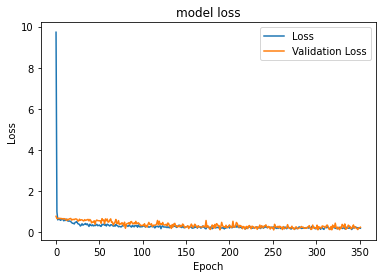

3023/3023 [==============================] - 189s 63ms/step
Test loss 0.21228388741518778
Test accuracy 0.9275553822517395
total train :  6046
true train :  3023
false train :  3023
0.5
0.5


<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

scores = model.evaluate(X_test, y_test, verbose=1)

print("Test loss", scores[0])
print("Test accuracy", scores[1])

print("total train : ", y_test.size)
print("true train : ", (y_test == 1).sum())
print("false train : ", (y_test == 0).sum())

print((y_test == 0).sum() / y_test.size)
print((y_test == 1).sum() / y_test.size)


128
not plane


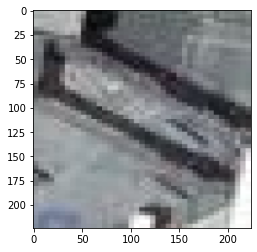

In [33]:
import random

print(random.randint(0, 1600))

#im = X_test[1600]
im = X_test[random.randint(0, 1600)]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

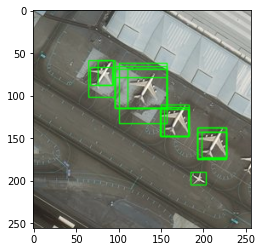

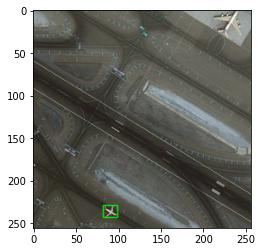

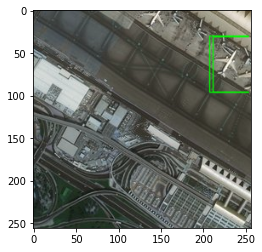

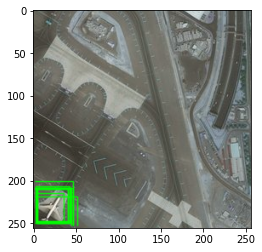

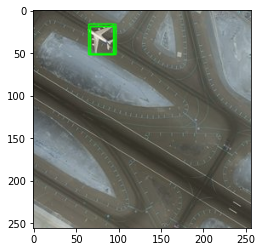

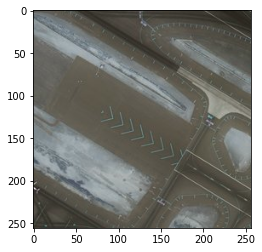

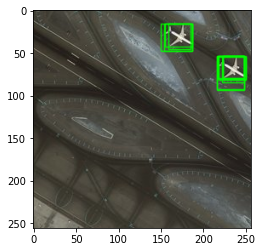

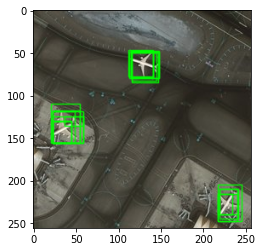

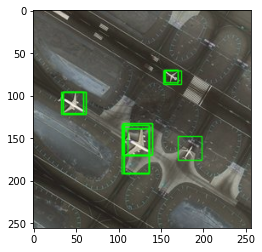

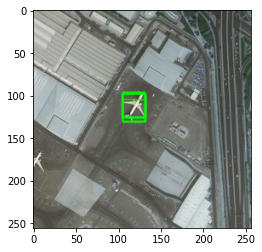

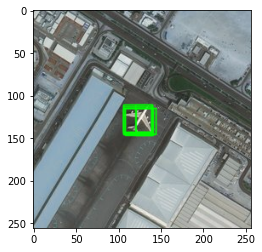

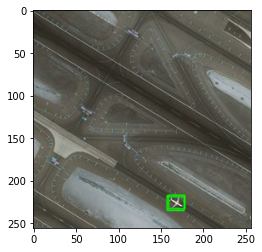

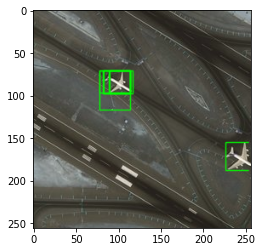

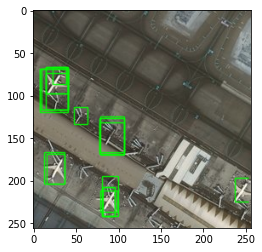

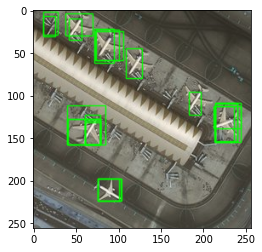

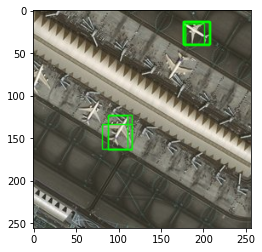

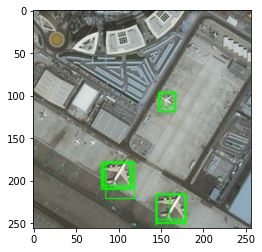

In [34]:
from keras.models import load_model

z=0

for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)

In [35]:
model_name = 'airplain_vgg_custom_adam.h5' 
save_dir = os.getcwd()

print(os.getcwd())

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

/home
Saved trained model at /home/airplain_vgg_custom_adam.h5 
